In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
%pylab inline
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from numpy.linalg import norm
from numpy import copy

from scipy.stats import probplot
import scipy as sp

from ipywidgets import FloatProgress
from IPython.display import display

import timeit

import fibonacci_heap_mod as fhm

from scipy.sparse import csr_matrix
from scipy import sparse

Populating the interactive namespace from numpy and matplotlib


## Постановка задачи

$$\begin{array}{lcl} f(x) = \frac{1}{2} \left\lVert Ax-y\right\rVert^{2} + \frac{\mu}{2} \left\lVert x\right\rVert^{2} \\
\nabla f(x) = \mu x + A^T  (Ax - y) \end{array}$$

Где $A$ -- плотная $m\cdot n$ матрица <br>
$y$ -- $m\cdot 1$ вектор ответов <br>
$x$ -- $n\cdot 1$ искомый вектор

Пусть:

$H = \widetilde{A}^T\widetilde{A} + \mu \widetilde{I}$

Где:

$\widetilde{A} = \begin{bmatrix} y & -X \end{bmatrix}$
$\widetilde{I} = \begin{bmatrix} 0 & 0 \\ 0 & I_n \end{bmatrix}$

Дополним пространство $D$ допустимых ответов как $\widetilde{D} = \{1\}\times D$, и перепишем исходную задачу как:

$\widetilde{f}(\beta) = \left(\widetilde{A}\beta\right)^T\left(\widetilde{A}\beta\right)^T + \beta^T\widetilde{I}\beta \to \min_\limits{\beta \in \widetilde{D}}$

Дифференцируя по $\beta$ получаем:

$\nabla \widetilde{f}(\beta) = H\beta$

Вводя $z_k = \frac{x_k}{b_k}$ сохраняя обозначения из статьи получаем, что:

$\arg \min H\beta_k \sim \arg\min H \begin{bmatrix}b_{k}^{-1} \\ z_k\end{bmatrix}$

## Тестирование алгоритма

Сгенерируем задачу

In [108]:
%%time

n = int(1e5)       # Размерность пространства. Осторожно: при порядке n = 10^8 памяти в 8 GB может не хватать
m = n              
mu = 1/n           # Коэффицент регуляризации в задаче Ridge
X = sparse.rand(m, n, density=5/n).tocsr()  # Матрица исходных данных Х размера [m*n], плотность = доля ненулевых эл-тов
x_true = sparse.rand(1, n, density=0.003).tocsr()  # Искомое решение             
x_true /= x_true.sum() # Решение живет на единичном симплексе
# Вектор Y ответов в регрессии искусственно делается всюду плотным плотным путем зашумления
y = X.dot(x_true.T) + sparse.rand(m, 1, density=1, format="csr")*0.000000000001 
print("%d non-zero elements in matrix X"%(len(X.nonzero()[1])))
print(x_true.count_nonzero(), "non-zero elements in x_true")
x0 = sparse.rand(1, n, density=1/n).tocsr() # Стартовая точка -- случайный угол симплекса

500000 non-zero elements in matrix X
300 non-zero elements in x_true
CPU times: user 1.87 s, sys: 165 ms, total: 2.03 s
Wall time: 2.14 s


Импортируем алгоритм из библиотеки (p.s. приветствуются предложения по имени для алгоритма)

In [ ]:
from lib.optimization import noname_algorithm

Описание параметров алгоритма:

* X -- матрица исходных данных [m*n]
* y -- вектор ответов в регрессии
* mu -- коэффицент регуляризации
* x0 -- начальная точка
* e -- относительная точность по квадрату нормы градиента. Критерий останова: ||g(xk)|| < e*||g(x0)||
* mode = "heap" | "full_grad" -- способ выбора координаты спуска: в режиме heap алгоритм поддерживает кучу на компонентах градиента, в режиме "full_grad" алгоритм берет простой argmin по его компонентам на каждом шаге
* step = "constant" | "paraboluc" -- способ выбора длины шага: в режиме constant длина шага k задается формулой 1/(1+k), в режиме parabolic длина шага ищется из точки минимума параболического приближения
* k_max -- максимальное число итераций
* history_elements -- если не пусто, то алгоритм логирует свою работу. Все перечисленные статистики заносятся в соответствующий список на каждом шаге. В конце работы эти списки статистик возвращаются в переменной history.

На каждом шаге в соответствующую компоненту history заносятся следующие величины:
* "g_norm" -- норма градиента функции 
* "x_norm" -- норма решения
* "d_sparsity" -- число ненулевых элементов в апдейте градиента
* "x_sparsity" -- число ненулевых элементов в текущем х
* "gamma" -- длина шага
* "f" -- значение функции в точке
* "time" -- время работы от начала (без учета препроцессинга данных)

По этим данным можно строить графики и смотреть за поведением алгоритма на разных данных

В качестве результата функция возвращает:
* x -- найденное решение
* message -- "success" | "iterations_exceeded" -- результат работы: успешное завершение поиска с заданной точностью, или же остановка при достижении предельного числа итераций

In [104]:
%%time
x, message, history = noname_algorithm(X, y, mu, x0, e = 1e-4, mode="heap", step="parabolic",
                                 k_max = 1e4,  history_elements=("g_norm","time","d_sparsity", "gamma", "x_sparsity", "x_norm"))
print(message)

success
CPU times: user 44.2 s, sys: 830 ms, total: 45 s
Wall time: 45.6 s


In [105]:
%%time
x_fix, message, history_fix = CCD_sparse(X, y, mu, x0, e = 1e-4, mode="heap", step="constant",
                                 k_max = 1e4,  history_elements=("g_norm","time","d_sparsity", "gamma"))
print(message)

success
CPU times: user 1min 31s, sys: 1.29 s, total: 1min 32s
Wall time: 1min 36s


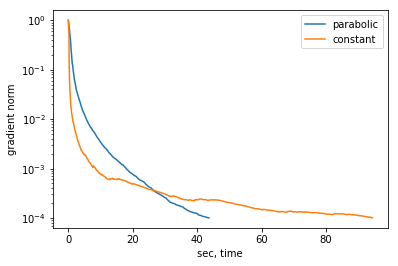

In [110]:
semilogy(history["time"], history["g_norm"], label = "parabolic")
semilogy(history_fix["time"], history_fix["g_norm"], label = "constant")
legend()
xlabel("sec, time")
ylabel("gradient norm")